In [1]:
import eland as ed
import numpy as np
import matplotlib.pyplot as plt
import os

from elasticsearch import Elasticsearch
from dotenv import load_dotenv
from notebooks.backtesting_utils import get_adx

os.chdir("..")
load_dotenv()

True

In [2]:
es_url = os.environ.get('ELASTICSEARCH_URL')
es_api_key = os.environ.get('ELASTICSEARCH_API_KEY')
es = Elasticsearch(hosts=[f"{es_url}"], api_key=es_api_key)

In [3]:
%%capture
ticker="IBM"
df_eod = ed.DataFrame(es, es_index_pattern="quant-agents_stocks-eod_*")
df_eod = df_eod[(df_eod.key_ticker == ticker)]
df_adx = ed.eland_to_pandas(df_eod).sort_values(by='date_reference', ascending=True).tail(100).set_index('date_reference')

period = 14
df_adx, df_crossovers = get_adx(df_adx)

In [4]:
df_adx.tail()

,key_ticker,val_close,val_high,val_low,val_open,val_volume,prev_high,prev_low,prev_close,plus_dm,minus_dm,tr,plus_di,minus_di,adx,position,returns,strategy
date_reference,,,,,,,,,,,,,,,,,,
2025-10-20,IBM,283.65,285.5000,280.9600,281.25,3494336,283.4000,275.3500,281.28,2.1000,0.0000,4.5400,28.723444,17.382031,35.307890,1,0.008390,0.008390
2025-10-21,IBM,282.05,285.3100,281.6000,283.31,4080981,285.5000,280.9600,283.65,0.0000,0.0000,3.7100,27.590801,16.696611,34.542958,1,-0.005657,-0.005657
2025-10-22,IBM,287.51,289.1700,281.3500,281.99,10538480,285.3100,281.6000,282.05,3.8600,0.0000,7.8200,29.379336,15.324874,34.321231,1,0.019173,0.019173
2025-10-23,IBM,285.00,285.5791,263.5623,264.95,16676394,289.1700,281.3500,287.51,0.0000,17.7877,23.9477,23.116099,27.892649,32.538585,-1,-0.008768,-0.008768
2025-10-24,IBM,307.46,310.7500,282.2100,283.77,16914243,285.5791,263.5623,285.00,25.1709,0.0000,28.5400,37.097047,21.900466,32.054257,1,0.075856,-0.075856


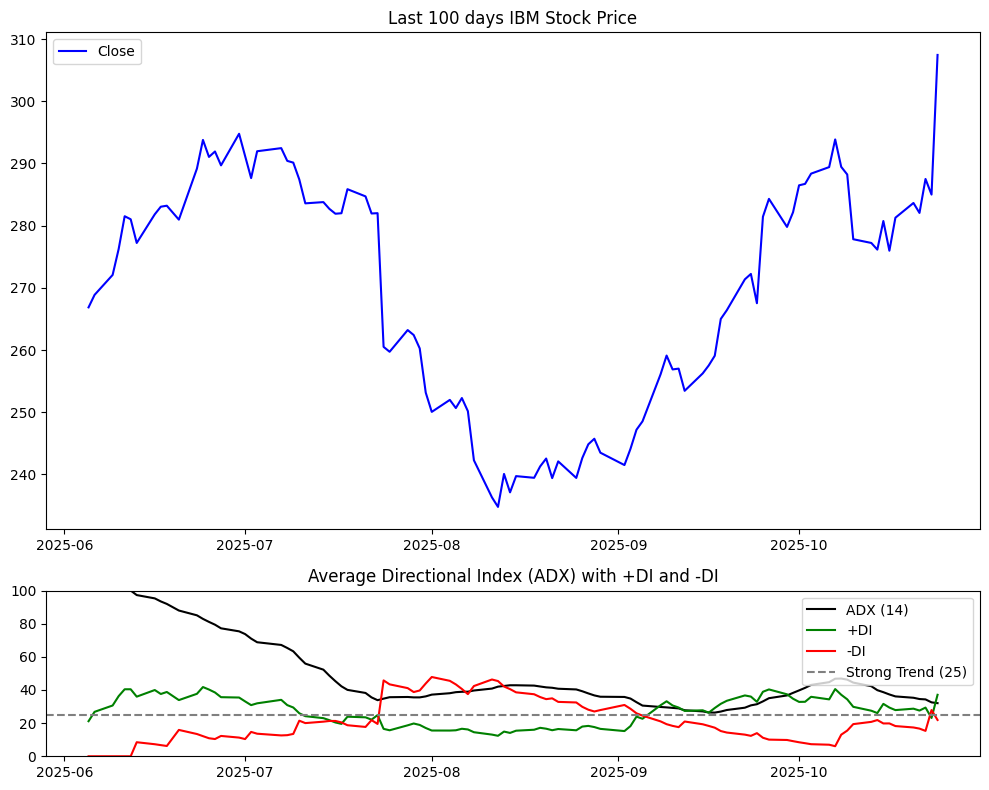

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]})

# Top: Price plot
axs[0].plot(df_adx.index, df_adx['val_close'], label='Close', color='blue')
axs[0].set_title(f"Last 100 days {ticker} Stock Price")
axs[0].legend()

# Bottom: ADX plot with +DI and -DI
axs[1].plot(df_adx.index, df_adx['adx'], label=f"ADX ({period})", color='black')
axs[1].plot(df_adx.index, df_adx['plus_di'], label='+DI', color='green')
axs[1].plot(df_adx.index, df_adx['minus_di'], label='-DI', color='red')
axs[1].axhline(25, color='gray', linestyle='--', label='Strong Trend (25)')
axs[1].set_title('Average Directional Index (ADX) with +DI and -DI')
axs[1].legend()
axs[1].set_ylim(0, 100)

plt.tight_layout()
plt.show()

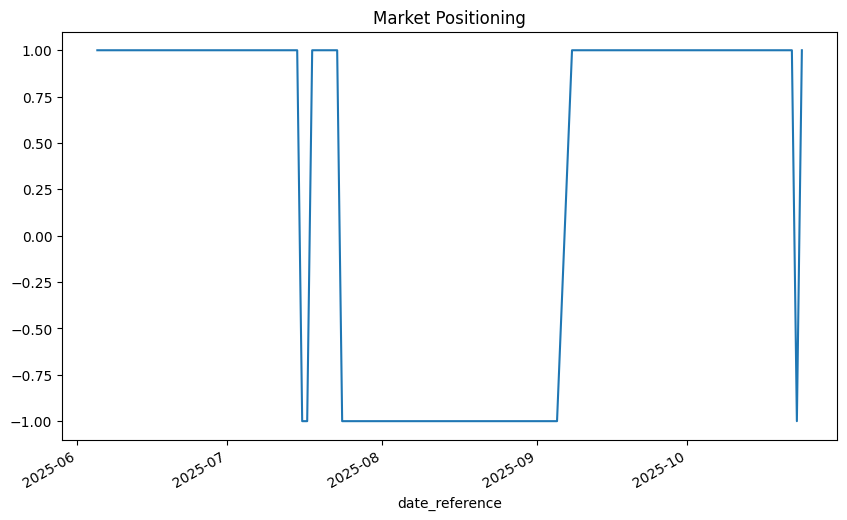

In [6]:
df_adx['position'].plot(
    ylim=[-1.1, 1.1],
    title='Market Positioning',
    figsize=(10, 6)
);

In [7]:
df_adx[['returns', 'strategy']].sum().apply(np.exp)

returns     1.152140
strategy    0.996313
dtype: float64

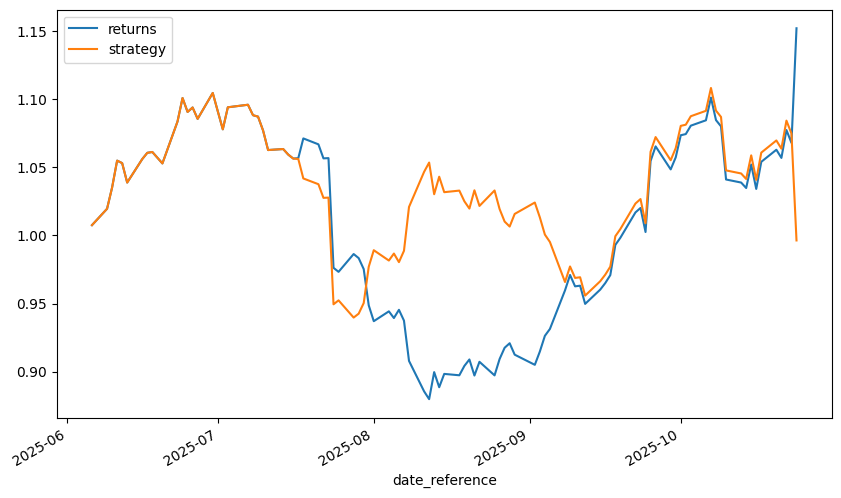

In [8]:
df_adx[['returns', 'strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(10, 6));

In [9]:
df_crossovers[['val_close', 'plus_di', 'minus_di', 'adx', 'position']]

,val_close,plus_di,minus_di,adx,position
date_reference,,,,,
2025-07-16,281.92,20.404557,21.314610,45.297184,-1
2025-07-18,285.87,23.885900,18.733741,40.065428,1
2025-07-24,260.51,16.545956,45.778590,34.779418,-1
2025-09-08,256.09,30.787459,21.055379,29.745967,1
2025-10-23,285.00,23.116099,27.892649,32.538585,-1
2025-10-24,307.46,37.097047,21.900466,32.054257,1
